In [7]:
import torch
import math

train_x = torch.linspace(0, 1, 12)
# True function is sin(2*pi*x) with Gaussian noise
train_y = train_x + torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [ ]:
import gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(input_size = 1)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [16]:
model.mean_module(train_x)

model(train_x).mean

tensor([-0.4570, -0.4403, -0.4237, -0.4070, -0.3904, -0.3738, -0.3571, -0.3405,
        -0.3238, -0.3072, -0.2905, -0.2739], grad_fn=<AddBackward0>)

In [48]:
# SIMULATED DATA EXPERIMENTS
# # RUN WITH python run_sim_experiments_dfNGPcm.py
# 
#       ooooooooooooooooooooooooooooooooooooo
#      8                                .d88
#      8  oooooooooooooooooooooooooooood8888
#      8  8888888888888888888888888P"   8888    oooooooooooooooo
#      8  8888888888888888888888P"      8888    8              8
#      8  8888888888888888888P"         8888    8             d8
#      8  8888888888888888P"            8888    8            d88
#      8  8888888888888P"               8888    8           d888
#      8  8888888888P"                  8888    8          d8888
#      8  8888888P"                     8888    8         d88888
#      8  8888P"                        8888    8        d888888
#      8  8888oooooooooooooooooooooocgmm8888    8       d8888888
#      8 .od88888888888888888888888888888888    8      d88888888
#      8888888888888888888888888888888888888    8     d888888888
#                                               8    d8888888888
#         ooooooooooooooooooooooooooooooo       8   d88888888888
#        d                       ...oood8b      8  d888888888888
#       d              ...oood888888888888b     8 d8888888888888
#      d     ...oood88888888888888888888888b    8d88888888888888
#     dood8888888888888888888888888888888888b
#
#
# This artwork is a visual reminder that this script is for the sim experiments.

model_name = "dfNGP"
from GPyTorch_models import dfNGP

# import configs to we can access the hypers with getattr
import configs
from configs import PATIENCE, MAX_NUM_EPOCHS, NUM_RUNS, WEIGHT_DECAY
# also import x_test grid size and std noise for training data
from configs import N_SIDE, STD_GAUSSIAN_NOISE
from configs import TRACK_EMISSIONS_BOOL

# Reiterating import for visibility
MAX_NUM_EPOCHS = MAX_NUM_EPOCHS
MAX_NUM_EPOCHS = 1000
NUM_RUNS = NUM_RUNS
NUM_RUNS = 1
WEIGHT_DECAY = WEIGHT_DECAY
PATIENCE = PATIENCE

# assign model-specific variable
MODEL_LEARNING_RATE = getattr(configs, f"{model_name}_SIM_LEARNING_RATE")
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")
import os
os.makedirs(MODEL_SIM_RESULTS_DIR, exist_ok = True)

# basics
import pandas as pd
import torch
import gpytorch

# universals 
from metrics import compute_divergence_field
from utils import set_seed, make_grid
import gc
import warnings
set_seed(42)

# setting device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# overwrite if needed: # device = 'cpu'
print('Using device:', device)
print()

### START TIMING ###
import time
start_time = time.time()  # Start timing after imports

### START TRACKING EXPERIMENT EMISSIONS ###
if TRACK_EMISSIONS_BOOL:
    from codecarbon import EmissionsTracker
    tracker = EmissionsTracker(project_name = "dfGP_simulation_experiments", output_dir = MODEL_SIM_RESULTS_DIR)
    tracker.start()

### SIMULATION ###
# Import all simulation functions
from simulate import (
    simulate_detailed_curve,
)

# Define simulations as a dictionary with names as keys to function objects
# alphabectic order here
simulations = {
    "curve": simulate_detailed_curve,
}

########################
### x_train & x_test ###
########################

# Load training inputs (once for all simulations)
x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False).float()

# Generate x_test (long) once for all simulations
_, x_test = make_grid(N_SIDE)
# x_test is long format (N_SIDE ** 2, 2)

#################################
### LOOP 1 - over SIMULATIONS ###
#################################

# Make y_train_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    ########################
    ### y_train & y_test ###
    ########################

    # Generate training observations
    # NOTE: sim_func() needs to be on CPU, so we move x_train to CPU
    y_train = sim_func(x_train.cpu()).to(device)
    y_test = sim_func(x_test.cpu()).to(device)
    
    x_test = x_test.to(device)
    x_train = x_train.to(device)

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Training inputs shape: {x_train.shape}")
    print(f"Training observations shape: {y_train.shape}")
    print(f"Training inputs dtype: {x_train.dtype}")
    print(f"Training inputs device: {y_train.device}")
    print(f"Training observations device: {y_train.device}")
    print()

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Test inputs shape: {x_test.shape}")
    print(f"Test observations shape: {y_test.shape}")
    print(f"Test inputs dtype: {x_test.dtype}")
    print(f"Test inputs device: {x_test.device}")
    print(f"Test observations device: {y_test.device}")
    print()

    # NOTE: This is different to the real data experiments
    # calculate the mean magnitude of the test data as we use this to scale the noise
    sim_mean_magnitude_for_noise = torch.norm(y_test, dim = -1).mean().to(device)
    sim_noise = STD_GAUSSIAN_NOISE * sim_mean_magnitude_for_noise

    # Store metrics for the simulation (used for *metrics_summary* report and *metrics_per_run*)
    simulation_results = [] 

    ##################################
    ### LOOP 2 - over training run ###
    ##################################

    # NOTE: GPs don't train on batches, use full data

    for run in range(NUM_RUNS):

        print(f"\n--- Training Run {run + 1}/{NUM_RUNS} ---")

        # Additive noise model: independent Gaussian noise
        # For every run we have a FIXED NOISY TARGET. Draw from standard normal with appropriate std
        y_train_noisy = y_train + (torch.randn(y_train.shape, device = device) * sim_noise)

        # Initialise the likelihood for the GP model (estimates noise)
        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

        # Intialise fresh GP model with flat x_train and y_train_noisy (block-flat)
        model = dfNGP(
            x_train.T.reshape(-1),
            y_train_noisy.T.reshape(-1), 
            likelihood,
            ).to(device)
        
        model.covar_module.outputscale = torch.tensor(0.00, device = device)  # Set initial scale to 1.0
        
        optimizer = torch.optim.AdamW([
            {"params": model.mean_module.parameters(), "weight_decay": WEIGHT_DECAY, "lr": (10 * MODEL_LEARNING_RATE)},
            # {"params": list(model.covar_module.parameters()) + list(model.likelihood.parameters()), "weight_decay": # WEIGHT_DECAY, "lr": MODEL_LEARNING_RATE},
            ])
                
        # Use ExactMarginalLogLikelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        model.train()
        likelihood.train()
        
        # _________________
        # BEFORE EPOCH LOOP

        # Export the convergence just for first run only
        if run == 0:
            # initialise tensors to store losses over epochs (for convergence plot)
            train_losses_NLML_over_epochs = torch.zeros(MAX_NUM_EPOCHS) # objective
            train_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS) # by-product
            # monitor performance transfer to test (only RMSE easy to calc without covar)
            test_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

            sigma_n_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            sigma_f_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            l1_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            l2_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

        # Early stopping variables
        best_loss = float('inf')
        # counter starts at 0
        epochs_no_improve = 0

        ############################
        ### LOOP 3 - over EPOCHS ###
        ############################

        print("\nStart Training")

        for epoch in range(MAX_NUM_EPOCHS):

            # Set to train
            model.train()
            likelihood.train()

            # Do a step
            optimizer.zero_grad()
            # model outputs a multivariate normal distribution
            train_pred_dist = model(x_train.T.reshape(-1).to(device))
            # Train on noisy or true targets?
            loss = - mll(train_pred_dist, y_train_noisy.T.reshape(-1).to(device))  # negative marginal log likelihood
            loss.backward()
            optimizer.step()

            # For Run 1 we save a bunch of metrics and update, while for the rest we only update
            if run == 0:

                model.eval()
                likelihood.eval()

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", gpytorch.utils.warnings.GPInputWarning)
                    train_pred_dist = model(x_train.T.reshape(-1).to(device))
                test_pred_dist = model(x_test.T.reshape(-1).to(device))

                # Compute RMSE for training and test predictions (given true data, not noisy)
                train_RMSE = torch.sqrt(gpytorch.metrics.mean_squared_error(train_pred_dist, y_train.T.reshape(-1).to(device)))
                test_RMSE = torch.sqrt(gpytorch.metrics.mean_squared_error(test_pred_dist, y_test.T.reshape(-1).to(device)))

                # Compute the RMSE from the mean only
                test_mean_module_RMSE = (model.mean_module(x_test.to(device)).detach() - y_test.to(device)).norm(dim = 1).mean()

Using device: cuda

=== CURVE ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32
Training inputs device: cuda:0
Training observations device: cuda:0

=== CURVE ===
Test inputs shape: torch.Size([400, 2])
Test observations shape: torch.Size([400, 2])
Test inputs dtype: torch.float32
Test inputs device: cuda:0
Test observations device: cuda:0


--- Training Run 1/1 ---

Start Training


In [56]:
x_train

tensor([[0.1667, 0.0000],
        [0.1500, 0.0333],
        [0.1333, 0.0667],
        [0.1167, 0.1000],
        [0.1000, 0.1333],
        [0.0833, 0.1667],
        [0.0667, 0.2000],
        [0.0500, 0.2333],
        [0.0333, 0.2667],
        [0.0167, 0.3000],
        [0.0000, 0.3333],
        [0.3333, 0.0000],
        [0.3137, 0.0294],
        [0.2941, 0.0588],
        [0.2745, 0.0882],
        [0.2549, 0.1176],
        [0.2353, 0.1471],
        [0.2157, 0.1765],
        [0.1961, 0.2059],
        [0.1765, 0.2353],
        [0.1569, 0.2647],
        [0.1373, 0.2941],
        [0.1176, 0.3235],
        [0.0980, 0.3529],
        [0.0784, 0.3824],
        [0.0588, 0.4118],
        [0.0392, 0.4412],
        [0.0196, 0.4706],
        [0.0000, 0.5000],
        [0.4000, 0.0000],
        [0.3800, 0.0300],
        [0.3600, 0.0600],
        [0.3400, 0.0900],
        [0.3200, 0.1200],
        [0.3000, 0.1500],
        [0.2800, 0.1800],
        [0.2600, 0.2100],
        [0.2400, 0.2400],
        [0.2

In [49]:
print(model.covar_module.outputscale)
mean_model_out = model.mean_module(x_test.to(device)).detach()

tensor(0., device='cuda:0', grad_fn=<SoftplusBackward0>)


In [ ]:
mean_model_out = model.mean_module(x_test.to(device)).detach()

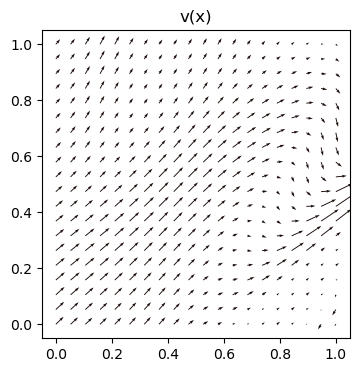

In [60]:
from visualise import visualise_v_quiver

visualise_v_quiver(
    mean_model_out, 
    x_test)

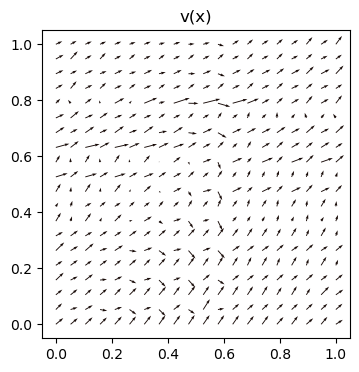

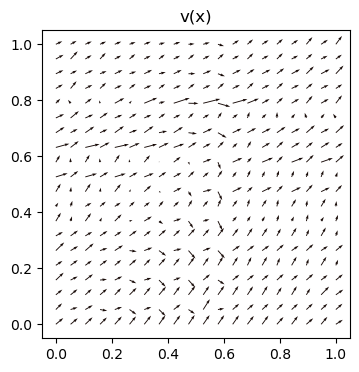

In [ ]:
test_pred_dist_likeli = likelihood(test_pred_dist)

visualise_v_quiver(
    test_pred_dist.mean.reshape(2, -1).T,
    x_test)

visualise_v_quiver(
    test_pred_dist_likeli.mean.reshape(2, -1).T,
    x_test)

In [ ]:
# self.covar_module = gpytorch.kernels.ZeroKernel()

AttributeError: module 'gpytorch.kernels' has no attribute 'ZeroKernel'

In [31]:
(model.mean_module(x_test.to(device)).detach() - y_test.to(device)).norm(dim = 1).mean()

tensor(0.7355, device='cuda:0')